In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt
from swath_rossby_wave import build_h_matrix2
from swath_rossby_wave import inversion

In [2]:
# define longitude/latitude domain, based on grid points in AVISO subsampled files
lonidx_west, lonidx_east  =  74, 110
latidx_south, latidx_north = 25, 65

In [3]:
# read AVISO SSH
aviso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = aviso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = aviso_ds.time.data[:] * 86400 # in seconds

lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data
dlon = lon - lon.mean()
dlat = lat - lat.mean()

In [4]:
ssha_time_mean = SSHA[:, :, : ].mean(axis = -1) # remove multi-year mean (climatology)

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
# remove mean from SSH data to produce anomaly over full analysis period
# obtain land masl
SSHA = SSHA - ssha_time_mean 
      # alternatively could remove 80-day mean  SSHA[day0 + day0 + 30].mean(axis = -1) 
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

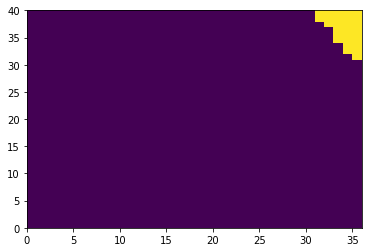

In [6]:
# plot land mask for reference
plt.pcolormesh(ssha_mask[:,:,0])

In [7]:
# set Rossby wave model parameters
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius
f0 =  2 * Omega * np.sin(Phi0*np.pi/180.) #1.0313e-4 

In [8]:
# number of modes to use---code only tested for MModes = 1
MModes = 1

In [9]:
# set zonal and meridional wavenumber increments and upper/lower bounds
# nominally assume a 10 x 10 degree domain, though we actually use a slightly rectangular domain
L_lat = 10 # domain latitude length degree 
L_lon = 10 # domain lognitude length

domain_factor = 1.1 # the smaller, the less waves

l_interval = 2 * np.pi / (domain_factor * L_lat) # zonal wavemenumber interval
k_interval = 2 * np.pi / (domain_factor * L_lon) # longitutional wavemenumber interval

lambda_min = 1.2 # 100km = 1 degree minimum wavelength resolved , the smaller, the more waves

#l_min = 0
#l_max = 2 * np.pi / lambda_min
#k_max = l_max
#k_min = -1 * l_max
k_min = 0  # stg:  changes to maintain consistent variable names
k_max = 2 * np.pi / lambda_min
l_max = k_max
l_min = -1 * k_max

In [10]:
# set range of k and l
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1  ###stg:  changes for variable name consistency
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
l_n = l_n_orig.reshape(len(l_n_orig), MModes) #* 0 # lon, zonal propagration 
k_n = k_n_orig.reshape(len(k_n_orig), MModes) #* 0 # lat, meridonal propagration

In [11]:
# set size of wavenumber domain
M = k_n.size * l_n.size

In [12]:
# load stratification, taken from numerical model
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
# parameters for Rossby wave model
Psi = strat_ds.Psi.data
Rm = 5e4  / 1e5 # 50 km to degree
wavespeed = Rm * f0  # deg / s strat_ds.C2[:MModes].data
Rm = np.array([Rm]) #unit: degree 

In [14]:
# define covariance matrix (R over P)
counter = 0
exp=-2
k0 = l_n.max() # flat at or below k0 

kl, R_over_P = np.zeros(2 * M), np.zeros([2 * M, 2 * M])
p_diagonal = np.zeros([2 * M])
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
R = 0.01 # noise = 1. cm
#R=0.
counter=0

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / p_diagonal / p_factor)

In [15]:
day0 = 0
day1 = 40
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [16]:
ndays=40
H_all, SSH_vector = build_h_matrix2(MSLA0, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, 0)

In [17]:
# create a dummy masked matrix in order to build the full H matrix
ssha_clean = np.ma.masked_invalid(np.zeros([MSLA0.shape[0],MSLA0.shape[1],MSLA0.shape[2]]))

In [18]:
# define matrices for first 40 days and last 40 days
H_all_full_grid, SSH_vector_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)
H_all_full_grid2, SSH_vector2_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, ndays)


In [19]:
# start dates:  first of the month in a leap year
day0_array = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

In [20]:
int(40/2)

20

In [21]:
# loop through all start dates and extract AVISO data and parameters for study region
# find fitted coefficients for Rossby wave model
# save clean fake data
persistence = np.zeros([SSHA_masked.shape[0],SSHA_masked.shape[1],int(ndays*2)])
iref=int(ndays/2)
for day0 in day0_array[:]:
    day1=day0+ndays
    time_range = (day1 - day0) * 2 # forecast time range
    
    MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 
    date_time = aviso_ds.date_time.data[day0:]
        
    variance_explained_inverse  = np.zeros(time_range)
    SSHA_vector=np.ma.compressed(MSLA0.transpose([2,0,1]).flatten())
    
    # least-squares fit to find best coefficients for non-land data points
    amp, ssh_estimated = inversion(SSHA_vector, H_all, R_over_P)
    
    # first 40 days
    MSLA_fwrd=np.matmul(H_all_full_grid, amp)
    MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
    MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
    MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
    # prediction period
    MSLA_fwrd2=np.matmul(H_all_full_grid2, amp)
    MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
    MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
    MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
    
    # ssh_reconstructed.shape
    MSLA_fwrd=np.ma.concatenate((MSLA_fwrd, MSLA_fwrd2),axis=2)
    
    residual = SSHA_masked[:,:,day0:day0+time_range] - MSLA_fwrd
    for i in range(time_range):
        persistence[:,:,i]=SSHA_masked[:,:,day0+iref]-SSHA_masked[:,:,day0+i]

    variance_explained_inverse = (np.mean(residual**2,axis=(0,1))) / (np.var(SSHA_masked[:,:,day0:day0+time_range],axis=(0,1)))
    variance_explained_persistence = (np.nanmean(persistence**2,axis=(0,1))) / (np.var(SSHA_masked[:,:,day0:day0+time_range],axis=(0,1)))
    
    ds_output = xr.Dataset(data_vars={'l_n' : l_n[:, 0],
                                  'k_n' : k_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), 1-variance_explained_inverse),
                                  'variance_explained_persistence': (('time'), 1-variance_explained_persistence),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'Rm': Rm,
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[:time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual, fit with ' 
                                                + str(day1 - day0) + '-day prior data.')))
    ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(k_n.size * l_n.size) +'waves_swotdomain_'+ str(int((day1 - day0))) +'days.nc')
    

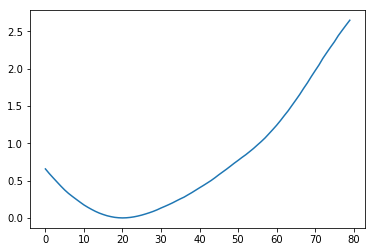

In [22]:
variance_explained_persistence = (np.nanmean(persistence**2,axis=(0,1))) / (np.var(SSHA_masked[:,:,day0:day0+time_range],axis=(0,1)))

plt.plot(variance_explained_persistence)